This analysis is following the recent disaster happened in Palu, Indonesia on 28th September 2018 
<br>Data is collected from https://earthquake.usgs.gov
<br>Filter applied to limit data based on coordinate,

In [1]:
# Import required libraries
import datetime
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize

# Data Collection

In [2]:
# set the date as 6th December 2004
# the program will loop for the number of iteration for a period of 30 days
baseDate = '28 September 2018'
rangeDate = 7    # we're collecting data 1 week before/after the baseDate

# set the boundaries of location (covering South East Asia)
latMin = -15
latMax = 15
lonMin = 90
lonMax = 140

In [3]:
# Custom function to record coordinate into separate lon/lat columns
# input : the coordinate as [longitude, latitude, depth]
# output : Series of lon/lat
def splitCoordinate(coor):
    lon,lat,elav = coor
    
    return pd.Series([lon,lat])

In [4]:
dt = datetime.datetime.strptime(baseDate, '%d %B %Y')

startDate = dt - datetime.timedelta(days=rangeDate)
endDate = dt + datetime.timedelta(days=rangeDate)

# construct the url used to download the data
urlStart = startDate.strftime("%Y-%m-%d")
urlEnd = endDate.strftime("%Y-%m-%d")
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime='+urlStart+'&endtime='+urlEnd

# submit the request
resp = requests.get(url=url)
data = resp.json()

# process the JSON response
block_df = json_normalize(data['features'])

# create new column for lon/lat
# so that we can scope the output only for the required region
block_df[['lon','lat']] = block_df['geometry.coordinates'].apply(splitCoordinate)

# define the boundaries based on lon/lat
location_latitude = (block_df['lat'] > latMin) & (block_df['lat'] < latMax)
location_longitude = (block_df['lon'] > lonMin) & (block_df['lon'] < lonMax)

# filter the response only to have earthquake on selected region
regional_df = block_df[ location_latitude & location_longitude ]

# combine the filtered response into master dataframe
master_df = pd.DataFrame()
master_df = master_df.append(regional_df, ignore_index = True)

master_df.head()

,geometry.coordinates,geometry.type,id,properties.alert,properties.cdi,properties.code,properties.detail,properties.dmin,properties.felt,properties.gap,...,properties.title,properties.tsunami,properties.type,properties.types,properties.tz,properties.updated,properties.url,type,lon,lat
0,"[120.0587, -1.2053, 10]",Point,us1000h7bb,None,NaN,1000h7bb,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.411,NaN,87.0,...,"M 4.5 - 40km SSE of Palu, Indonesia",0,earthquake,",geoserve,origin,phase-data,",480,1538692359040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,120.0587,-1.2053
1,"[120.5781, -1.1493, 10]",Point,us1000h79w,None,NaN,1000h79w,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.195,NaN,79.0,...,"M 4.4 - 31km NNW of Kasiguncu, Indonesia",0,earthquake,",geoserve,origin,phase-data,",480,1539117939040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,120.5781,-1.1493
2,"[101.8232, -4.6372, 23.66]",Point,us1000h777,None,NaN,1000h777,https://earthquake.usgs.gov/fdsnws/event/1/que...,3.347,NaN,106.0,...,"M 4.7 - 104km SSW of Bengkulu, Indonesia",0,earthquake,",geoserve,origin,phase-data,",420,1539117184040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,101.8232,-4.6372
3,"[120.3148, -1.3154, 10]",Point,us1000h774,None,NaN,1000h774,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.455,NaN,126.0,...,"M 4.6 - 39km WNW of Kasiguncu, Indonesia",0,earthquake,",geoserve,origin,phase-data,",480,1539095934040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,120.3148,-1.3154
4,"[128.5938, 2.161, 10]",Point,us1000h6yd,None,NaN,1000h6yd,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.846,NaN,161.0,...,"M 4.5 - 80km NE of Tobelo, Indonesia",0,earthquake,",geoserve,origin,phase-data,",540,1538668737040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,128.5938,2.1610


# Process the Collected Data

In [5]:
# Check on the shape of the dataframe, which give total data we collected
master_df.shape

(112, 32)

<b>112 earthquakes</b> rocks the area within 1 week before and after 28th September 2018

In [6]:
# Check on the available columns
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 32 columns):
geometry.coordinates    112 non-null object
geometry.type           112 non-null object
id                      112 non-null object
properties.alert        10 non-null object
properties.cdi          10 non-null float64
properties.code         112 non-null object
properties.detail       112 non-null object
properties.dmin         112 non-null float64
properties.felt         10 non-null float64
properties.gap          112 non-null float64
properties.ids          112 non-null object
properties.mag          112 non-null float64
properties.magType      112 non-null object
properties.mmi          10 non-null float64
properties.net          112 non-null object
properties.nst          0 non-null float64
properties.place        112 non-null object
properties.rms          112 non-null float64
properties.sig          112 non-null int64
properties.sources      112 non-null object
properties.sta

For earthquake we probably interested to know:

1. When it happened (date/time) --> properties.time
2. What was the magnitude --> properties.mag
3. Where it happened --> properties.place
4. Coordinate so that it can be plotted --> geometry.coordinates

Details of the availble data can be found from https://earthquake.usgs.gov/data/comcat/data-eventterms.php

In [7]:
# make a copy of the original dataframe
#earthquake_df = master_df[['geometry.coordinates','properties.mag','properties.place','properties.time','lon','lat']].copy()
earthquake_df = master_df.copy()

In [8]:
# Times are reported in milliseconds since the epoch, and provided in UTC
# good to convert this into human readable format

def convertEpochToReadable(dt):
    time1 = float(dt/1000)
    dt_date = datetime.datetime.fromtimestamp(time1).strftime('%d-%m-%Y')
    dt_time = datetime.datetime.fromtimestamp(time1).strftime('%H:%M:%S')
    
    return pd.Series([dt_date, dt_time])

print 'Converted\t:',convertEpochToReadable(master_df['properties.time'][0])

Converted	: 0    05-10-2018
1      06:08:34
dtype: object


In [9]:
# apply the function
earthquake_df[['date','time']] = earthquake_df['properties.time'].apply(convertEpochToReadable)
earthquake_df.head()

,geometry.coordinates,geometry.type,id,properties.alert,properties.cdi,properties.code,properties.detail,properties.dmin,properties.felt,properties.gap,...,properties.type,properties.types,properties.tz,properties.updated,properties.url,type,lon,lat,date,time
0,"[120.0587, -1.2053, 10]",Point,us1000h7bb,None,NaN,1000h7bb,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.411,NaN,87.0,...,earthquake,",geoserve,origin,phase-data,",480,1538692359040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,120.0587,-1.2053,05-10-2018,06:08:34
1,"[120.5781, -1.1493, 10]",Point,us1000h79w,None,NaN,1000h79w,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.195,NaN,79.0,...,earthquake,",geoserve,origin,phase-data,",480,1539117939040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,120.5781,-1.1493,05-10-2018,04:40:31
2,"[101.8232, -4.6372, 23.66]",Point,us1000h777,None,NaN,1000h777,https://earthquake.usgs.gov/fdsnws/event/1/que...,3.347,NaN,106.0,...,earthquake,",geoserve,origin,phase-data,",420,1539117184040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,101.8232,-4.6372,05-10-2018,02:27:40
3,"[120.3148, -1.3154, 10]",Point,us1000h774,None,NaN,1000h774,https://earthquake.usgs.gov/fdsnws/event/1/que...,2.455,NaN,126.0,...,earthquake,",geoserve,origin,phase-data,",480,1539095934040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,120.3148,-1.3154,05-10-2018,02:27:22
4,"[128.5938, 2.161, 10]",Point,us1000h6yd,None,NaN,1000h6yd,https://earthquake.usgs.gov/fdsnws/event/1/que...,1.846,NaN,161.0,...,earthquake,",geoserve,origin,phase-data,",540,1538668737040,https://earthquake.usgs.gov/earthquakes/eventp...,Feature,128.5938,2.1610,04-10-2018,21:57:19


In [10]:
# add mangnitude class label
# ref: http://www.geo.mtu.edu/UPSeis/magnitude.html

def addClass(mag):
    if (mag>=8):
        return 'Great'
    elif (mag>=7):
        return 'Major'
    elif (mag>=6):
        return 'Strong'
    elif (mag>=5):
        return 'Moderate'
    elif (mag>=4):
        return 'Light'
    elif (mag>=3):
        return 'Minor'
    else:
        return 'Not felt'

# Apply the class on the dataframe
earthquake_df['Class'] = earthquake_df['properties.mag'].apply(addClass)

# Inspect the modified dataframe
earthquake_df.loc[0:5,['properties.mag','Class']]

,properties.mag,Class
0,4.5,Light
1,4.4,Light
2,4.7,Light
3,4.6,Light
4,4.5,Light
5,4.6,Light


In [11]:
# export to CSV
filename = 'E:\DataScience\Jupyter\Earthquake\\data\\regional-' + str(urlStart) + '-' + str(urlEnd) + '.csv'
earthquake_df.to_csv(filename)

# Visualize the Data

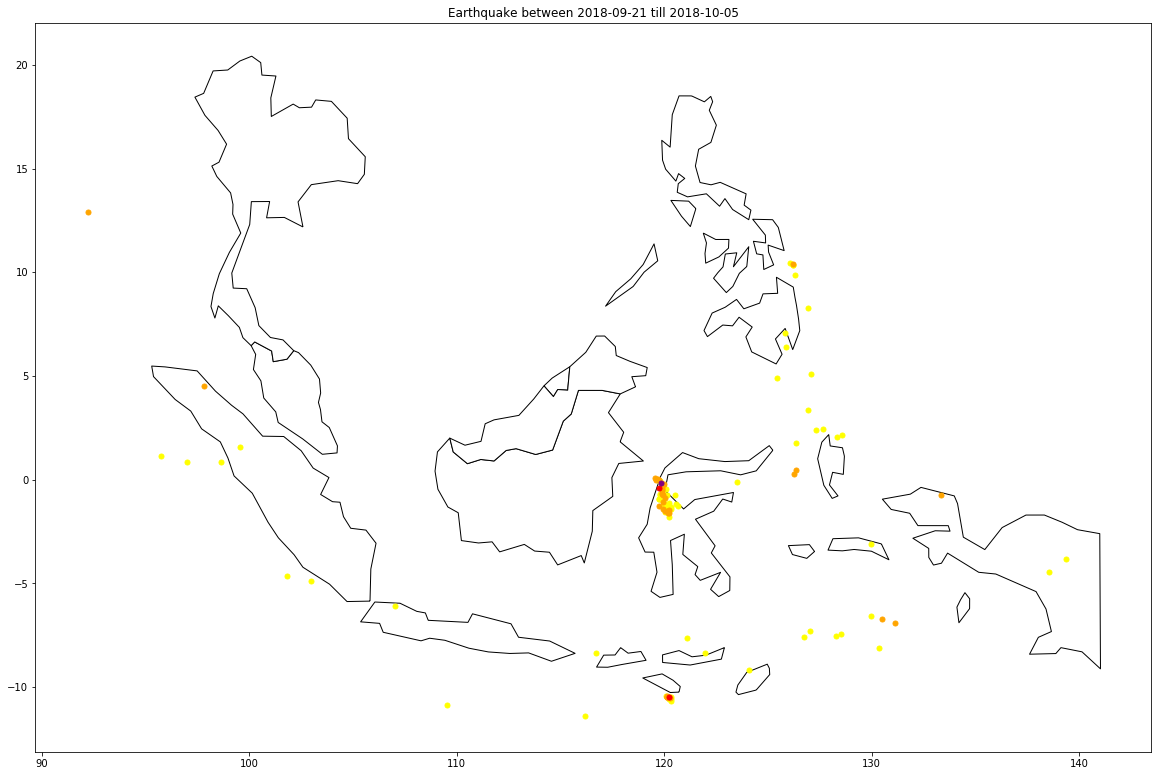

In [13]:
# let's plot on the map
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

crs = {'init': 'epsg:4326'}
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[(world.name=="Indonesia") | (world.name=="Philippines") \
              | (world.name=="Malaysia") | (world.name=="Brunei") \
              | (world.name=="Brunei") | (world.name=="Thailand")]

from matplotlib import cm

base = world.plot(figsize=(20,20),color='white', edgecolor='black')
base.set_title("Earthquake between "+urlStart+" till "+urlEnd)

colorDict = {'Great': 'darkred', # >8
             'Major': 'purple', # >7
             'Strong': 'red', # >6
             'Moderate': 'orange', # >5
             'Light': 'yellow', # >4
             'Minor': 'darkgreen', # >3
             'Not felt': 'cyan' # <3
            }

classType = ['Not felt','Minor','Light','Moderate','Strong','Major','Great']
#classType = ['Moderate','Strong','Major','Great']
for cType in classType:
    if(len(earthquake_df[earthquake_df['Class']==cType])>0):
        subsetDF = earthquake_df[earthquake_df['Class']==cType]
        geometry = [Point(xy) for xy in zip(subsetDF.lon, subsetDF .lat)]
        subsetGDF = GeoDataFrame(subsetDF, crs=crs, geometry=geometry)
    
        subsetGDF.plot(ax=base, marker='.', color=colorDict[cType], markersize=100);

From the map, we can see many occurance of earthquakes around the same area in Palu.
<br>Let's focus only on that area, filter by coordinates.

# Inspect only area of focus

In [14]:
# Create a copy of dataframe with only covering the Northen Acheh area
# Roughly get the boundaries from the map above
location_latitude = (earthquake_df['lat'] > -5) & (earthquake_df['lat'] < 5)
location_longitude = (earthquake_df['lon'] > 118) & (earthquake_df['lon'] < 121)

palu_df = earthquake_df[location_latitude & location_longitude].copy()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

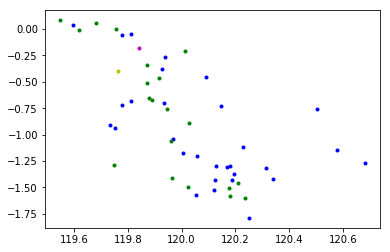

In [17]:
# Just plot into xy-plane to check on the earthquake as we intended
markerDict = {'Great': 'ro', # >8 red
             'Major': 'mo', # >7 magenta
             'Strong': 'yo', # >6 yellow
             'Moderate': 'go', # >5 green
             'Light': 'bo', # >4 blue
             'Minor': 'co', # >3 minor
             'Not felt': 'wo' # <3 white
            }

for cls in palu_df.Class.unique():
    clscFilter = palu_df['Class']==cls
    plt.plot(palu_df[clscFilter].lon,palu_df[clscFilter].lat, markerDict[cls],markersize=3)

Text(0.5,1,u'Number of earthquake by day')

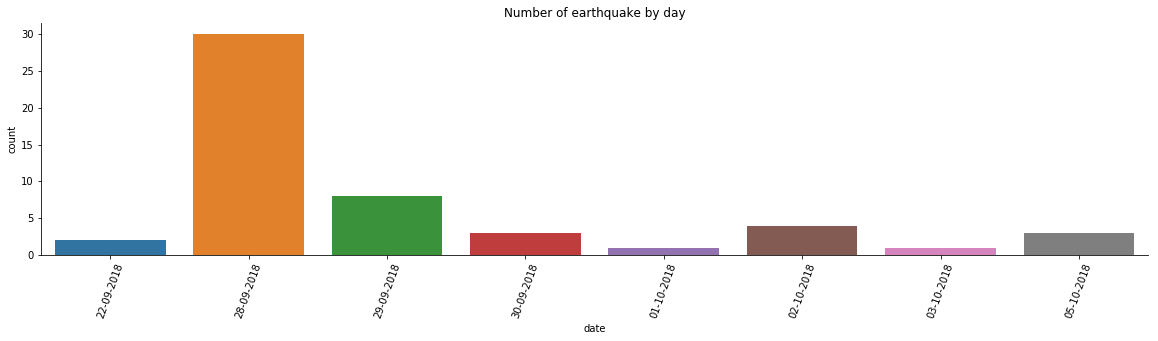

In [18]:
# Check the count by day

sns.factorplot('date',data=palu_df.sort_values(by='properties.time', ascending=1),kind='count',
               orient="h",aspect=4,legend=True)

plt.xticks(rotation=70)
plt.title("Number of earthquake by day")

In [19]:
palu_df.groupby(['date'])['geometry.coordinates'].nunique()

date
01-10-2018     1
02-10-2018     4
03-10-2018     1
05-10-2018     3
22-09-2018     2
28-09-2018    30
29-09-2018     8
30-09-2018     3
Name: geometry.coordinates, dtype: int64

28 September recorded the most earthquakes that hit the area.
<br>Also there were significant number of earquakes a day after.
<br>Let's plot the earthquake for these 2 days, and illustrate the magnitude level

Text(0.5,1,u'Number of earthquakes between 26-29 December')

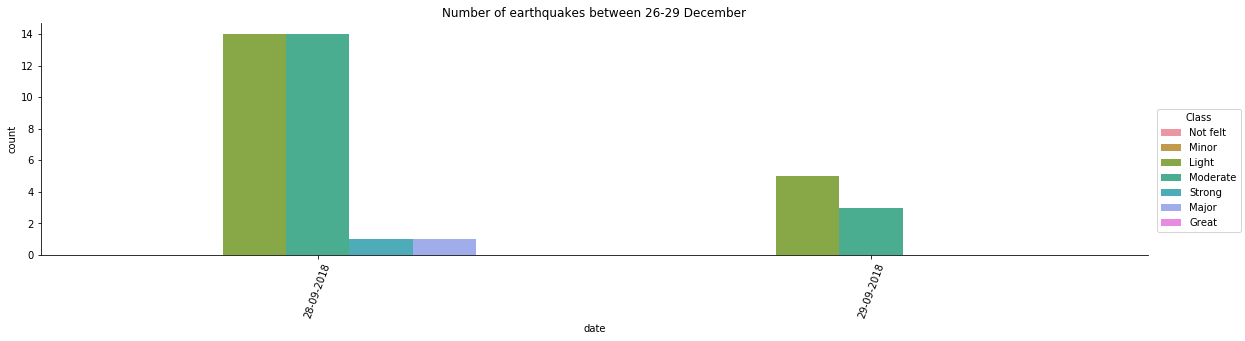

In [41]:
# High volume happened between 28-29 September 2018

dateFilter = (palu_df['date']>='28-09-2018') & (palu_df['date']<'30-09-2018')

classPalette = sns.color_palette("YlOrRd", earthquake_df['Class'].nunique())
sns.set_palette(classPalette)

sns.factorplot('date',data=palu_df[dateFilter].sort_values(by='properties.time', ascending=1),hue='Class',kind='count',
               orient="h",aspect=4,legend=True,hue_order = ['Not felt','Minor','Light','Moderate','Strong','Major','Great'])

plt.xticks(rotation=70)
plt.title("Number of earthquakes between 26-29 December")

The area was hit by 30 earthquake on 28 September
<br>half of it with magnitude >5

In [22]:
dateFilter = (palu_df['date']>='26-12-2004') & (palu_df['date']<'29-12-2004')
palu_df[dateFilter].groupby(['date','Class'])['geometry.coordinates'].nunique()

date        Class   
28-09-2018  Light       14
            Major        1
            Moderate    14
            Strong       1
29-09-2018  Light        5
            Moderate     3
Name: geometry.coordinates, dtype: int64

The area was hit by major earthquakes on 28 September, with 30 earthquakes with magnitude >=5 (Moderate=14 Strong=1 Major=1)
<br>Let's visualize these on xy-plot

# What happened on 28 September

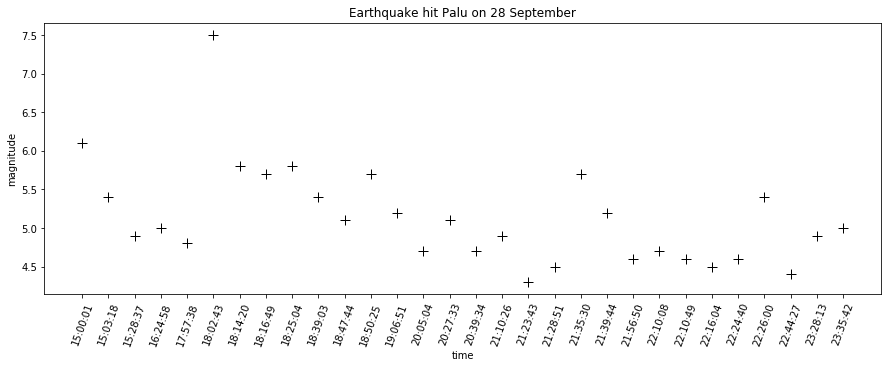

In [25]:
plt.figure(figsize=(15,5))

magnFilter = palu_df['properties.mag']>=5
dateFilter = palu_df['date']=='28-09-2018'

plt.plot(palu_df[dateFilter]['time'],
        palu_df[dateFilter]['properties.mag'],
         '+k',markersize=10) # black cross

plt.xticks(rotation=70)
plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("Earthquake hit Palu on 28 September")

plt.show()

In [27]:
# list down the earthquake with magnitude > 6
magnFilter = palu_df['properties.mag']>=5
dateFilter = palu_df['date']=='28-09-2018'

palu_df[dateFilter & magnFilter] \
    .sort_values(by='time', ascending=1) \
    [['properties.place','date','time','Class','properties.mag']]

,properties.place,date,time,Class,properties.mag
80,"55km NNW of Palu, Indonesia",28-09-2018,15:00:01,Strong,6.1
79,"77km NNE of Palu, Indonesia",28-09-2018,15:03:18,Moderate,5.4
77,"60km N of Palu, Indonesia",28-09-2018,16:24:58,Moderate,5.0
74,"78km N of Palu, Indonesia",28-09-2018,18:02:43,Major,7.5
73,"99km N of Palu, Indonesia",28-09-2018,18:14:20,Moderate,5.8
72,"17km E of Palu, Indonesia",28-09-2018,18:16:49,Moderate,5.7
71,"21km SSE of Palu, Indonesia",28-09-2018,18:25:04,Moderate,5.8
70,"24km N of Palu, Indonesia",28-09-2018,18:39:03,Moderate,5.4
69,"42km N of Palu, Indonesia",28-09-2018,18:47:44,Moderate,5.1
68,"17km NNE of Palu, Indonesia",28-09-2018,18:50:25,Moderate,5.7


On 28 September, the area was hit by <b>M6.1</b> earthquake at <b>3 pm</b>
<br>Followed <b>M7.5</b> earthquake at <b>6 pm</b>

# Let's see details on the greatest earthquake on 28 September

In [28]:
# Get the greatest earthquake
dateFilter = palu_df['date']=='28-09-2018'
maxFilter = palu_df['properties.mag'] == palu_df['properties.mag'].max()

palu_df[dateFilter & maxFilter] \
    .sort_values(by='time', ascending=1) \
    [['properties.place','date','time','Class','properties.mag','properties.detail']]

,properties.place,date,time,Class,properties.mag,properties.detail
74,"78km N of Palu, Indonesia",28-09-2018,18:02:43,Major,7.5,https://earthquake.usgs.gov/fdsnws/event/1/que...


In [29]:
# more details can be retrieved as follow
palu_df.loc[palu_df['properties.mag'].idxmax()]

geometry.coordinates                              [119.8401, -0.1781, 10]
geometry.type                                                       Point
id                                                             us1000h3p4
properties.alert                                                      red
properties.cdi                                                        8.4
properties.code                                                  1000h3p4
properties.detail       https://earthquake.usgs.gov/fdsnws/event/1/que...
properties.dmin                                                     1.589
properties.felt                                                        18
properties.gap                                                         27
properties.ids                                    ,us1000h3p4,us1000h4p4,
properties.mag                                                        7.5
properties.magType                                                    mww
properties.mmi                        

The greatest earthquake on 28th September was with <b>magnitude 7.5</b>, happened <b>6 pm</b>.
<br>The exact location was <b>78km N of Palu, Indonesia</b>

In [31]:
# get the detail from the properties.detail
detailURL = palu_df.loc[palu_df['properties.mag'].idxmax()]['properties.detail']
detailURL

u'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us1000h3p4&format=geojson'

From this URL, we can get more details of each earthquake.
<br>I have inspect the json response, and will only focus on some data captured:
1. general-header
2. general-header
3. impact-text
4. poster

In [32]:
# submit the request
resp = requests.get(url=detailURL)
data = resp.json()

# process the JSON response
block_df = json_normalize(data['properties']['products'])

block_df

,dyfi,finite-fault,general-text,geoserve,ground-failure,losspager,moment-tensor,origin,phase-data,poster,shakemap
0,"[{u'status': u'UPDATE', u'updateTime': 1538462...","[{u'status': u'UPDATE', u'updateTime': 1539123...","[{u'status': u'UPDATE', u'updateTime': 1538587...","[{u'status': u'UPDATE', u'updateTime': 1538130...","[{u'status': u'UPDATE', u'updateTime': 1538519...","[{u'status': u'UPDATE', u'updateTime': 1538519...","[{u'status': u'UPDATE', u'updateTime': 1538131...","[{u'status': u'UPDATE', u'updateTime': 1538130...","[{u'status': u'UPDATE', u'updateTime': 1538130...","[{u'status': u'UPDATE', u'updateTime': 1538151...","[{u'status': u'UPDATE', u'updateTime': 1538519..."


In [35]:
headerBlock = block_df['general-text']
type(headerBlock)

pandas.core.series.Series

In [36]:
from IPython.core.display import display, HTML

for h1 in headerBlock:
    #print "h1 is",type(h1)    # list
    for h2 in h1:
        #print "h2 is",type(h2)  # dict
        h2Content = h2['contents']
        #print "h2Content is",type(h2Content)  # dict
        #print h2Content['']['bytes']
        display(HTML(h2Content['']['bytes']))

In [39]:
from IPython.display import Image
from IPython.core.display import HTML

imgUrl = ""

posterBlock = block_df['poster']
for h1 in posterBlock:
    #print "h1 is",type(h1)    # list
    for h2 in h1:
        #print "h2 is",type(h2)  # dict
        imgUrl = h2['contents']['poster.jpg']['url']
        print imgUrl

Image(url= imgUrl)

https://earthquake.usgs.gov/archive/product/poster/20180928/us/1538151889786/poster.jpg
